# Project Report
My findings are summarized here, and this notebook should be checked into the repository with all its detailed output. If you have the database and encrypted files set up, you can re-run this whole notebook to reproduce the results or evaluate how a new model performs.

There are two models, one that guesses keys from texts encrypted by the Caesar Cipher, and one that guesses text directly. The key model consistently works better. This table shows various accuracy metrics, tested against text files that were not used at all for training. The metric definitions are expanded below:

![](accuracy_table.png "Caesar Model Accuracy Table")

The models use LSTM layers, which iterate through data, so the output is rather complex. At least for the key model, you can actually see how the prediction accuracy improves as it iterates:

![](accuracy_graph.png "Caesar Model Accuracy Improving Through Iteration")

## Setup

In [1]:
# Imports

import os
import logging
import sys

# Disable some chatty warnings from Tensorflow:
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"

# Still trying to disable warnings. It's harder than you'd think!
logging.getLogger('tensorflow').disabled = True

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import random
import pandas as pd
import sys
import time

from credentials import CONNECTION_INFO
from constants import *

import encoders
import db_connect
import helpers
import tf_helpers
import models
import crackers

# Callbacks for use with TensorFlow
from tf_helpers import modulo_output, modulo_distance_loss, modulo_distance_accuracy, modulo_rounded_accuracy, initialize_save_best

2024-12-02 23:31:43.246980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 23:31:43.272067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 23:31:43.280089: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
ENCODER = encoders.ENCODER_CAESAR

CAESAR_KEY_MODEL = models.load_model(models.CAESAR_KEY_MODEL_PATH)
CAESAR_TEXT_MODEL = models.load_model(models.CAESAR_TEXT_MODEL_PATH)
CAESAR_CHUNK_SIZE = CAESAR_TEXT_MODEL.input_shape[2]
CAESAR_KEY_SIZE = 1
CAESAR_SCALER = helpers.load_scaler_from_file(helpers.get_recommended_scaler_path(encoders.ENCODER_CAESAR, CAESAR_CHUNK_SIZE, temp=False))

CAESAR_CRACKER = crackers.Caesar_Cracker(CAESAR_SCALER, CAESAR_KEY_MODEL, CAESAR_TEXT_MODEL, verbose=0)

KEY_BATCH_SIZE = 256
TEXT_BATCH_SIZE = 32

# You may need to limit test size for memory reasons, espescially for the text model.
# Set to -1 to disable the limit.
KEY_INPUT_CHUNK_LIMIT = -1
TEXT_INPUT_CHUNK_LIMIT = 10000

I0000 00:00:1733211106.661641  178715 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733211106.794156  178715 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733211106.794208  178715 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733211106.797788  178715 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733211106.797853  178715 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

# Test Data Retrieval and Shaping

In [3]:
# Get some test data. This all comes from texts that have not been used for training at all.
db = db_connect.DB(CONNECTION_INFO)

with db.get_session() as session:
    # Get database IDs for encoders and key types
    (encoder_ids, key_type_id) = db.get_id_maps(session)

    # Map source ID to plaintext file (1) details, and source ID to corresponding ciphertext files (1+) details.
    # Only files from a "test only" source will be returned.
    (sid_to_p, sid_to_c) = db.get_source_maps(session, -1, encoder_ids[ENCODER], test_only=True)

    # Get the features (X, the cipher texts as offsets) and targets (y, either the plain texts as offsets OR the key).
    (X, y_keys, y_texts) = db.get_features_and_targets(
            session, sid_to_p, sid_to_c, ENCODER, CAESAR_CHUNK_SIZE, 
            want_keys=True, want_texts=True)

# We may want to limit how many we test with, for memory reasons
key_feature_limit = min(len(X), KEY_INPUT_CHUNK_LIMIT) if KEY_INPUT_CHUNK_LIMIT > -1 else len(X)
text_feature_limit = min(len(X), TEXT_INPUT_CHUNK_LIMIT) if TEXT_INPUT_CHUNK_LIMIT > -1 else len(X)

# Put into Numpy arrays for easier handling
X_for_keys = np.array(X[0:key_feature_limit])
X_for_texts = np.array(X[0:text_feature_limit])
y_keys = np.array(y_keys[0:key_feature_limit])
y_texts = np.array(y_texts[0:text_feature_limit])

del X

print(f"There are {len(sid_to_p)} original sources and {len(sid_to_c)} encrypted files")
print(f"There are {X_for_keys.shape[0]} chunks of ciphertext for the key model, and {X_for_texts.shape[0]} for the text model.")
print("Shapes: ", X_for_keys.shape, X_for_texts.shape, y_keys.shape, y_texts.shape)

There are 8 original sources and 8 encrypted files
There are 41410 chunks of ciphertext for the key model, and 10000 for the text model.
Shapes:  (41410, 256) (10000, 256) (41410,) (10000, 256)


In [4]:
# Scale and shape the data
X_for_keys_scaled = CAESAR_SCALER.transform(X_for_keys)
X_for_texts_scaled = CAESAR_SCALER.transform(X_for_texts)

X_for_keys_scaled = tf_helpers.reshape_input_for_RNN(X_for_keys_scaled, CAESAR_CHUNK_SIZE)
X_for_texts_scaled = tf_helpers.reshape_input_for_RNN(X_for_texts_scaled, CAESAR_CHUNK_SIZE)
y_keys = tf_helpers.reshape_output_for_RNN(y_keys, CAESAR_KEY_SIZE)
y_texts = tf_helpers.reshape_output_for_RNN(y_texts, CAESAR_CHUNK_SIZE)

X_for_keys_scaled.shape, X_for_texts_scaled.shape, y_keys.shape, y_texts.shape

((41410, 256, 1), (10000, 256, 1), (41410, 1, 1), (10000, 256, 1))

# Basic Functionality and Metrics

## Data Structure

To make things cleaner, I simplified the texts to all uppercase and removed most special characters.

Tensorflow models work on numbers, not letters, so I needed a way to represent the input numerically. At first I just used ASCII codes, but they are nonconsequential and don't start at 0, so that made the problem harder than necessary. I settled on representing each character as its index in my simplified character set. Note numbers, punctuation, and whitespace characters are included; traditionally those would be left alone, providing big clues to whoever wanted to crack the code.

Because Tensorflow models need a fixed input size, the text is broken into "chunks". The current process actually causes some duplication near the end of the input.

Finally, everything needs to be put into lists or arrays for efficient handling. The shape of the data, espescially as output by the model, was actually a major stumbling point for me. I still don't really get what the model is doing. I just think I know where to look for good numbers.

This is all demonstrated in the cell below.

In [5]:
initial_text = "Resumé.       spaces."
simplified = encoders.encode_simple(initial_text)
offsets = encoders.string_to_offsets(simplified)
chunks = helpers.chunkify(offsets, 4)

# Simplification cannot be reverse, but everything else can be:
unchunked = np.array(chunks).flatten()
reconstructed = encoders.offsets_to_string(unchunked)

print(f"Initial text      : {initial_text}")
print(f"Simplified text   : {simplified}")
print(f"Encoded as offsets: {offsets}")
print(f"Chunked           : {chunks}")
print(f"Reconstructed     : {reconstructed} -- note it doesn't match perfectly, which is a known issue")
print()
print("Shapes of the data we're actually using in this notebook:")
print(f"X / features (chunks of ciphertext): {X_for_keys.shape}")
print(f"y / targets for the key model      : {y_keys.shape}")
print(f"y / targets for the text model     : {y_texts.shape}")

Initial text      : Resumé.       spaces.
Simplified text   : RESUME. SPACES.
Encoded as offsets: [17, 4, 18, 20, 12, 4, 55, 60, 18, 15, 0, 2, 4, 18, 55]
Chunked           : [[17, 4, 18, 20], [12, 4, 55, 60], [18, 15, 0, 2], [2, 4, 18, 55]]
Reconstructed     : RESUME. SPACCES. -- note it doesn't match perfectly, which is a known issue

Shapes of the data we're actually using in this notebook:
X / features (chunks of ciphertext): (41410, 256)
y / targets for the key model      : (41410, 1, 1)
y / targets for the text model     : (10000, 256, 1)


## Metrics as Gathered by Tensorflow

Tensorflow provides some basic accuracy functions, but I had to add some custom ones. The main problem is that the cipher algorithms treat values as essentially circular. If there are 60 possible characters, ranged 0-59, then numbers 2 and 58 are only 4 away from each other. Tensorflow's metrics would treat them as 56 away from each other, leading to at best misleading results.

In other words, it needs to do modular arithmetic.

The are the custom metrics I've used:
* **modulo_distance_loss (MDL)**: My loss function, returning the distance between true and predicted values.
* **modulo_distance_accuracy (MDA)**: My main accuracy function, very similar to loss, but with distance expressed as percentage away from maximum. So it goes up as the results get better!
* **modulo_rounded_accuracy (MRA)**: A more intuitive, but less mathematically helpful, accuracy calculation. It rounds the values (as would be done for final use of the output) and returns the percent of predictions which exactly match true values.

I suspect I am not consistently using metric functions correctly. Functions like Model.evaluate() may be returning misleading values. This is illustrated by the fact that my loss function returns slightly different results when used as a loss function, as opposed to a metric, in the same run.

The next cell gathers these basic metrics, as reported by Model.evaluate():

In [6]:
# Use Model.evaluate() to gather some basic metrics across the whole test set

# Associate some interesting metrics with the models:
#
# From Tensorflow:
# Mean Squared Error (MSE) is often good for a loss function.
# Accuracy is meant mainly for classification, but might be somewhat relevant
#
# My functions are described above.
loss_metric = modulo_distance_loss
all_metrics = [modulo_distance_loss, modulo_distance_accuracy, modulo_rounded_accuracy, "mse", "accuracy"]

# Names for the dataframe, must line up with evaluate() output
metric_names = ["MDL as Loss", "MDL", "MDA", "MRA", "(TF) MSE", "(TF) Accuracy"]

CAESAR_KEY_MODEL.compile(loss=loss_metric, optimizer=PREFERRED_OPTIMIZER, metrics=all_metrics)
CAESAR_TEXT_MODEL.compile(loss=loss_metric, optimizer=PREFERRED_OPTIMIZER, metrics=all_metrics)

key_results = CAESAR_KEY_MODEL.evaluate(X_for_keys_scaled, y_keys, batch_size=KEY_BATCH_SIZE, verbose=0)
text_results = CAESAR_TEXT_MODEL.evaluate(X_for_texts_scaled, y_texts, batch_size=TEXT_BATCH_SIZE, verbose=0)

evaluate_df = pd.DataFrame({
    "Metric": metric_names,
    "Key Model": key_results, 
    "Text Model": text_results })
    

# Put my preferred metrics back in for later testing
loss_metric = modulo_distance_loss
all_metrics = [modulo_distance_accuracy, modulo_rounded_accuracy]
CAESAR_KEY_MODEL.compile(loss=loss_metric, optimizer=PREFERRED_OPTIMIZER, metrics=all_metrics)
CAESAR_TEXT_MODEL.compile(loss=loss_metric, optimizer=PREFERRED_OPTIMIZER, metrics=all_metrics)

evaluate_df

,Metric,Key Model,Text Model
0,MDL as Loss,0.601246,1.123931
1,MDL,0.600890,1.124421
2,MDA,0.980617,0.963728
3,MRA,0.626832,0.452254
4,(TF) MSE,91.183128,172.364807
5,(TF) Accuracy,0.041742,0.003678


## Comparison to Direct Accuracy Calculations

In [7]:
# Call predict() directly, extract the values we'd actually want to use, and calculate accuracy in a nice simple way
key_predictions = CAESAR_KEY_MODEL.predict(X_for_keys_scaled, verbose=0, batch_size=KEY_BATCH_SIZE)
text_predictions = CAESAR_TEXT_MODEL.predict(X_for_texts_scaled, verbose=0, batch_size=TEXT_BATCH_SIZE)

key_predictions.shape, text_predictions.shape

((41410, 256, 1), (10000, 256, 256))

## Output Data Structure
The model outputs predictions in a particular shape, which apparently corresponds to the prediction getting refined as the LSTM layer moves through the input. So instead of one prediction, you get 256 (the chunk size I've been using).

Both models produce 3-dimensional output, but the key model is only size 1 along the final axis. So it's easier to work with. The shape is:
    (feature index, chunk size, 1)

The final key predictions are at the end of the 2nd dimension.

The text model output has this shape:
    (feature index, chunk size, chunk size)
... and for some reason, the final predictions seem to be at the end of 3rd dimension, not the 2nd. I do not know why.

In [8]:
best_keys = key_predictions[:, CAESAR_CHUNK_SIZE-1, :]
best_texts = text_predictions[:, :, CAESAR_CHUNK_SIZE-1]

best_keys.shape, best_texts.shape, y_keys.shape, y_texts.shape

((41410, 1), (10000, 256), (41410, 1, 1), (10000, 256, 1))

## Direct Accuracy Calculations
This cell calculates accuracy in a much more straightforward, understandable, transparent way. It just gets the value that would actually be used from the prediction, and counts how many of the predictions are exactly right.

This shows that my custom metric functions are in the right ballpark, especially MRA, when used with evaluate(). But they're quite lining up with what one would expect.

In [9]:
# The predictions come out as floating point values, so round and convert to integer. Not rounding caused me a lot of pain!
# The predictions and true values are effectively the same shape now (true values have another dimension, but it's size 1),
# but we need to flatten them some more to get numpy to use memory effiently enough to do, well, math. 

best_keys_flat = best_keys.round().astype(int).flatten()
best_texts_flat = best_texts.round().astype(int)

y_keys_flat = y_keys.round().astype(int).flatten()
y_texts_flat = y_texts[:,:,0].round().astype(int)

# Keys are simple to compare now, but text prediciotns require some more assembly.
# Here is an example of how:
sample_true_string = encoders.offsets_to_string(y_texts_flat[0,:])
sample_predicted_string = encoders.offsets_to_string(best_texts_flat[0,:])
print("A true string:")
print(f"{sample_true_string[0: min(64,len(sample_true_string))]}...")
print()
print("A predicted string:")
print(f"{sample_predicted_string[0: min(64,len(sample_predicted_string))]}...")

# I'm pulling this to a function because I want to do something deeper later in this notebook.
# Returns a tuple: (key_model_score, text_model_score)
def get_direct_accuracy(key_preds_flat, text_preds_flat) -> tuple[float, float]:

    # Just count how many keys match:
    good_keys = (key_preds_flat == y_keys_flat).astype(int).sum()
    key_count = len(key_preds_flat)
    good_key_percent = float(good_keys) / float(key_count)

    # Now the text model...
    good_chars = 0
    bad_chars = 0
    total_chars = 0
    for i in range(text_preds_flat.shape[0]):
        true_string = encoders.offsets_to_string(y_texts_flat[i,:])
        predicted_string = encoders.offsets_to_string(text_preds_flat[i,:])
    
        # Count the matching characters
        (this_good, this_bad, this_total, _) = helpers.good_bad_string_match(true_string, predicted_string)
        good_chars += this_good
        bad_chars += this_bad
        total_chars += this_total
    good_text_percent = float(good_chars) / float(total_chars)

    return (good_key_percent, good_text_percent)
   
(good_key_percent, good_text_percent) = get_direct_accuracy(best_keys_flat, best_texts_flat)

# Add these to the Dataframe
new_row = pd.DataFrame({"Metric": ["Direct Accuracy"], "Key Model": [good_key_percent], "Text Model": [good_text_percent]})
evaluate_df = pd.concat([evaluate_df, new_row], ignore_index=True)

print()
print(f"The key model produced the right key {good_key_percent:.2%} of the time.")
print(f"The text model got {good_text_percent:.2%} of the characters right.")

evaluate_df

A true string:


PRODUCED BY GREG WEEKS, MARY MEEHAN AND THE ONLINE
DISTRIBUTED...

A predicted string:
HFTSPDSBDD CT
FREG UDDJT??MAQT
LDDGAM AND UHE POMJOFAEJUTJIBUTDD...

The key model produced the right key 71.38% of the time.
The text model got 45.30% of the characters right.


,Metric,Key Model,Text Model
0,MDL as Loss,0.601246,1.123931
1,MDL,0.600890,1.124421
2,MDA,0.980617,0.963728
3,MRA,0.626832,0.452254
4,(TF) MSE,91.183128,172.364807
5,(TF) Accuracy,0.041742,0.003678
6,Direct Accuracy,0.713765,0.453007


## Accuracy Improving as Model Iterates
Because the model outputs ALL its predictions as it iterates through the input, we can see how it improves, at least for the key model. The text model seems to hit its ideal accuracy right away; more likely, there's something I don't understand.

In [18]:
# Iterate through the outputs, which seem to be organized a bit differently between key and text models.

offsets = []
key_acc = []
text_acc = []
for i in range(CAESAR_CHUNK_SIZE):
    i_keys = key_predictions[:, i, :]
    i_texts = text_predictions[:, :, i]
    i_keys_flat = i_keys.round().astype(int).flatten()    
    i_texts_flat = i_texts.round().astype(int)
    (good_key_percent, good_text_percent) = get_direct_accuracy(i_keys_flat, i_texts_flat)

    offsets.append(i)
    key_acc.append(good_key_percent)
    text_acc.append(good_text_percent)
    

offset_accuracy_df = pd.DataFrame({
    "Iteration": offsets,
    "Key Model Accuracy": key_acc,
    "Text Model Accuracy": text_acc
}).set_index("Offset")
offset_accuracy_df.describe()

0000: G
0001: G
0002: G
0003: G
0004: G
0005: G
0006: G
0007: G
0008: G
0009: G
0010: G
0011: G
0012: G
0013: G
0014: G
0015: G
0016: G
0017: G
0018: G
0019: G
0020: G
0021: G
0022: G
0023: G
0024: G
0025: G
0026: G
0027: G
0028: G
0029: G
0030: G
0031: G
0032: G
0033: G
0034: G
0035: G
0036: G
0037: G
0038: G
0039: G
0040: G
0041: G
0042: G
0043: G
0044: G
0045: G
0046: G
0047: G
0048: G
0049: G
0050: G
0051: G
0052: G
0053: G
0054: G
0055: G
0056: G
0057: G
0058: G
0059: G
0060: G
0061: G
0062: G
0063: G
0064: G
0065: G
0066: G
0067: G
0068: G
0069: G
0070: G
0071: G
0072: G
0073: G
0074: G
0075: G
0076: G
0077: G
0078: G
0079: G
0080: G
0081: G
0082: G
0083: G
0084: G
0085: G
0086: G
0087: G
0088: G
0089: G
0090: G
0091: G
0092: G
0093: G
0094: G
0095: G
0096: G
0097: G
0098: G
0099: G
0100: G
0101: G
0102: G
0103: G
0104: G
0105: G
0106: G
0107: G
0108: G
0109: G
0110: G
0111: G
0112: G
0113: G
0114: G
0115: G
0116: G
0117: G
0118: G
0119: G
0120: G
0121: G
0122: G
0123: G
0124: G


,Key Model,Text Model
Offset,,
0,0.035475,0.453234
1,0.066433,0.453438
2,0.095532,0.453819
3,0.127892,0.451822
4,0.156508,0.452427
...,...,...
251,0.713016,0.452220
252,0.713910,0.452277
253,0.714900,0.453419


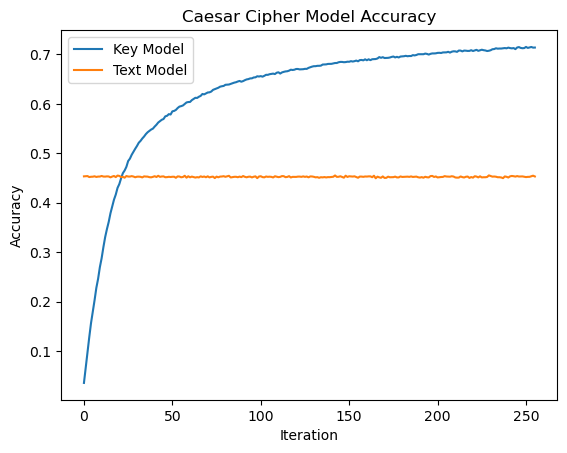

In [29]:
mean_offset_acc_df = offset_accuracy_df.groupby(['Offset']).mean()
plot = mean_offset_acc_df.plot(title='Caesar Cipher Model Accuracy', xlabel="Iteration", ylabel="Accuracy")
fig = plot.get_figure()
fig.savefig('temp_accuracy_graph.png')